In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# For DICOM conversion
import pydicom
import cv2

print("TensorFlow version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.17.1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Define paths for DICOM images and the target PNG folder.
TRAIN_DCM_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
PNG_DIR = "/content/rsna-dataset/train_png"
os.makedirs(PNG_DIR, exist_ok=True)

# List all DICOM files
dcm_files = [f for f in os.listdir(TRAIN_DCM_DIR) if f.endswith(".dcm")]

# Conversion: Read each DICOM, normalize, and save as PNG.
for i, filename in enumerate(dcm_files):
    dcm_path = os.path.join(TRAIN_DCM_DIR, filename)
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array.astype(np.float32)
    # Normalize the pixel values to 0-255
    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    img_norm = (img_norm * 255).astype(np.uint8)
    # Optionally convert to 3 channels (DenseNet201 expects 3-channel input)
    img_rgb = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2RGB)

    # Save the image
    png_filename = filename.replace(".dcm", ".png")
    png_path = os.path.join(PNG_DIR, png_filename)
    cv2.imwrite(png_path, img_rgb)

    if i % 500 == 0:
        print(f"Converted {i}/{len(dcm_files)} images")

print("DICOM to PNG conversion complete!")


Converted 0/26684 images
Converted 500/26684 images
Converted 1000/26684 images
Converted 1500/26684 images
Converted 2000/26684 images
Converted 2500/26684 images
Converted 3000/26684 images
Converted 3500/26684 images
Converted 4000/26684 images
Converted 4500/26684 images
Converted 5000/26684 images
Converted 5500/26684 images
Converted 6000/26684 images
Converted 6500/26684 images
Converted 7000/26684 images
Converted 7500/26684 images
Converted 8000/26684 images
Converted 8500/26684 images
Converted 9000/26684 images
Converted 9500/26684 images
Converted 10000/26684 images
Converted 10500/26684 images
Converted 11000/26684 images
Converted 11500/26684 images
Converted 12000/26684 images
Converted 12500/26684 images
Converted 13000/26684 images
Converted 13500/26684 images
Converted 14000/26684 images
Converted 14500/26684 images
Converted 15000/26684 images
Converted 15500/26684 images
Converted 16000/26684 images
Converted 16500/26684 images
Converted 17000/26684 images
Converted

In [37]:
# not implementing this now

# import os, json

# # Step 1: Define the dataset directory (where your PNGs already are)
# DATASET_DIR = "/kaggle/working/train_png_dataset"
# os.makedirs(DATASET_DIR, exist_ok=True)

# # Step 2: Move your existing PNG folder into the dataset directory
# !mv /kaggle/working/train_png "$DATASET_DIR/train_png"

# # Step 3: Create Kaggle metadata
# dataset_metadata = {
#     "title": "RSNA PNG Dataset Converted from DICOM",
#     "id": "zainchuck/rsna-png-dataset",  # 🔁 Your Kaggle username
#     "licenses": [{"name": "CC0-1.0"}],
#     "private": True  # Set to False if you want a public dataset
# }

# with open(f"{DATASET_DIR}/dataset-metadata.json", "w") as f:
#     json.dump(dataset_metadata, f)

# # Step 4: Upload to Kaggle
# !kaggle datasets create -p "$DATASET_DIR" -u


In [38]:
# Paths for label CSV files
TRAIN_LABELS_CSV = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"


# Load the train labels
train_labels = pd.read_csv(TRAIN_LABELS_CSV)

# Create a binary label: if any bounding box exists, label as Pneumonia (1), else Normal (0)
train_labels['pneumonia_label'] = train_labels.apply(
    lambda row: 1 if (row['x'] + row['y'] + row['width'] + row['height']) > 0 else 0,
    axis=1
)

# Group by patientId to get a single label per image
label_df = train_labels.groupby('patientId')['pneumonia_label'].sum().reset_index()
label_df['pneumonia_label'] = label_df['pneumonia_label'].apply(lambda x: 1 if x > 0 else 0)

# Update the file path to point to the PNG images we just converted.
label_df['filepath'] = label_df['patientId'].apply(lambda x: os.path.join(PNG_DIR, x + ".png"))

print("Sample labels:")
print(label_df.head())


Sample labels:
                              patientId  pneumonia_label  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6                0   
1  000924cf-0f8d-42bd-9158-1af53881a557                0   
2  000db696-cf54-4385-b10b-6b16fbb3f985                1   
3  000fe35a-2649-43d4-b027-e67796d412e0                1   
4  001031d9-f904-4a23-b3e5-2c088acd19c6                1   

                                            filepath  
0  /content/rsna-dataset/train_png/0004cfab-14fd-...  
1  /content/rsna-dataset/train_png/000924cf-0f8d-...  
2  /content/rsna-dataset/train_png/000db696-cf54-...  
3  /content/rsna-dataset/train_png/000fe35a-2649-...  
4  /content/rsna-dataset/train_png/001031d9-f904-...  


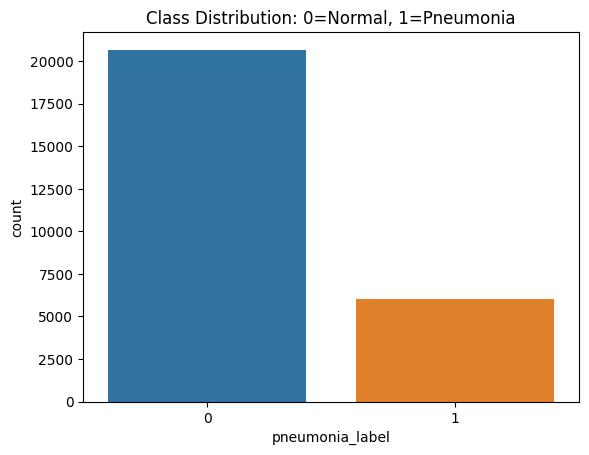

Computed class weights: {0: 0.6454140866873065, 1: 2.2192282102461744}


In [6]:
# Visualize class distribution
sns.countplot(x='pneumonia_label', data=label_df)
plt.title("Class Distribution: 0=Normal, 1=Pneumonia")
plt.show()

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

labels_array = label_df['pneumonia_label'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_array),
    y=labels_array
)
class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)


In [7]:
from sklearn.model_selection import train_test_split

# Split data by patientId to avoid leakage.
train_df, val_df = train_test_split(
    label_df,
    test_size=0.2,
    stratify=label_df['pneumonia_label'],
    random_state=42
)

print("Train size:", train_df.shape, "Val size:", val_df.shape)

# Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Define data generators with augmentation for training.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="pneumonia_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",  # Using raw because labels are 0/1.
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="pneumonia_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)


Train size: (21347, 3) Val size: (5337, 3)
Found 21347 validated image filenames.
Found 5337 validated image filenames.


In [8]:
# Load DenseNet201 without the top layers
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze all layers initially for training the custom head
for layer in base_model.layers:
    layer.trainable = False

# Build the custom head
x = base_model.output
x = SpatialDropout2D(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 18,444,993 (70.36 MB)

 Trainable params: 123,009 (480.50 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [9]:
# Custom Focal Loss Function for Binary Classification
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Custom focal loss implementation.

    Args:
        gamma: focusing parameter that reduces the relative loss for well-classified examples.
        alpha: balancing factor to address class imbalance (default 0.25).

    Returns:
        A loss function to be used in model.compile().
    """
    def loss_fn(y_true, y_pred):
        # Clip predictions to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Compute binary cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Compute focal loss scaling factor
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy

        return tf.reduce_mean(loss)

    return loss_fn

# Example usage: compile your model with the custom focal loss
loss_function = focal_loss(gamma=2.0, alpha=0.25)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Make sure your 'model' variable is defined (from your previous cell where you build DenseNet201)
model.compile(optimizer=optimizer, loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc')])

print("Model compiled successfully with custom focal loss.")


Model compiled successfully with custom focal loss.


In [10]:
# Define callbacks for early stopping, learning rate reduction, and saving the best model.
# Note: The file extension is changed to .keras to meet the new requirements.
callbacks = [
    EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint("best_model.keras", monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

print("Callbacks defined successfully.")


Callbacks defined successfully.


In [12]:
# initial_epochs = 5
# history_head = model.fit(
#     train_generator,
#     epochs=initial_epochs,
#     validation_data=val_generator,
#     callbacks=callbacks,
#     class_weight=class_weights_dict,
#     verbose=1
# )


Epoch 1/5
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - auc: 0.7316 - loss: 0.0729
Epoch 1: val_auc improved from 0.78768 to 0.81056, saving model to best_model.keras
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 916s 683ms/step - auc: 0.7316 - loss: 0.0729 - val_auc: 0.8106 - val_loss: 0.0543 - learning_rate: 1.0000e-04
Epoch 2/5
1334/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - auc: 0.7493 - loss: 0.0572
Epoch 2: val_auc improved from 0.81056 to 0.81247, saving model to best_model.keras
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 904s 674ms/step - auc: 0.7493 - loss: 0.0572 - val_auc: 0.8125 - val_loss: 0.0473 - learning_rate: 1.0000e-04
Epoch 3/5
1334/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - auc: 0.7516 - loss: 0.0522
Epoch 3: val_auc improved from 0.81247 to 0.81527, saving model to best_model.keras
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 885s 660ms/step - auc: 0.7516 - loss: 0.0522 - val_auc: 0.8153 - val_loss: 0.0459 - learning_rate: 1.0000e-04
Epoch 4/5
1334/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - auc: 0.7626 - lo

In [14]:
!pip install tf2onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 10.7 MB/s eta 0:00:0000:01


In [15]:
# Save model in .h5 format (Keras native format)
model.save("model.h5")
print("Model saved as model.h5")

# Convert and save the model in ONNX format
import tf2onnx
import onnx

# Create an input signature based on the model's input shape.
# Adjust the shape as needed; here we assume the first dimension is None (batch size)
input_spec = (tf.TensorSpec(model.input.shape, tf.float32, name="input"),)

# Convert the Keras model to ONNX and save it
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=input_spec, opset=13, output_path="model.onnx")
print("Model saved in ONNX format as model.onnx")

# Save the model in .pkl format by pickling its architecture and weights
import pickle

# Get the model architecture as JSON and weights as a list
model_json = model.to_json()
model_weights = model.get_weights()

# Create a dictionary to hold the architecture and weights
model_dict = {"architecture": model_json, "weights": model_weights}

# Dump the dictionary to a pickle file
with open("model.pkl", "wb") as f:
    pickle.dump(model_dict, f)

print("Model saved in pickle format as model.pkl")


Model saved as model.h5
Model saved in ONNX format as model.onnx
Model saved in pickle format as model.pkl


In [19]:
# Unfreeze the last 50 layers of DenseNet for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a lower learning rate
optimizer_finetune = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_finetune, loss=loss_function, metrics=[tf.keras.metrics.AUC(name='auc')])

fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - auc: 0.7839 - loss: 0.0488
Epoch 1: val_auc improved from 0.81629 to 0.83113, saving model to best_model.keras
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 952s 680ms/step - auc: 0.7839 - loss: 0.0488 - val_auc: 0.8311 - val_loss: 0.0435 - learning_rate: 1.0000e-05
Epoch 2/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - auc: 0.7953 - loss: 0.0468
Epoch 2: val_auc improved from 0.83113 to 0.84037, saving model to best_model.keras
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 879s 656ms/step - auc: 0.7953 - loss: 0.0468 - val_auc: 0.8404 - val_loss: 0.0420 - learning_rate: 1.0000e-05
Epoch 3/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - auc: 0.8089 - loss: 0.0459
Epoch 3: val_auc improved from 0.84037 to 0.84816, saving model to best_model.keras
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 866s 646ms/step - auc: 0.8089 - loss: 0.0459 - val_auc: 0.8482 - val_loss: 0.0409 - learning_rate: 1.0000e-05
Epoch 4/10
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - auc: 0.8293 

In [24]:
print("Min:", np.min(preds))
print("Max:", np.max(preds))
print("Mean:", np.mean(preds))


Min: 0.06574156
Max: 0.4951386
Mean: 0.2676209


In [25]:
from sklearn.metrics import f1_score
import numpy as np

best_thresh = 0.0
best_f1 = 0.0

for thresh in np.linspace(0, 0.5, 51):  # try thresholds from 0 to 0.5
    temp_preds = (preds > thresh).astype(int)
    score = f1_score(true_labels, temp_preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print("Best threshold:", best_thresh)
print("Best F1:", best_f1)


Best threshold: 0.34
Best F1: 0.625


334/334 ━━━━━━━━━━━━━━━━━━━━ 135s 404ms/step - auc: 0.8674 - loss: 0.0374
Validation Loss: 0.03834054619073868
Validation AUC: 0.8648186326026917
334/334 ━━━━━━━━━━━━━━━━━━━━ 138s 414ms/step
Predictions shape: (5337,)
Predicted labels shape: (5337,)
True labels shape: (5337,)
Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.83      0.87      4135
   Pneumonia       0.55      0.73      0.62      1202

    accuracy                           0.80      5337
   macro avg       0.73      0.78      0.75      5337
weighted avg       0.83      0.80      0.81      5337



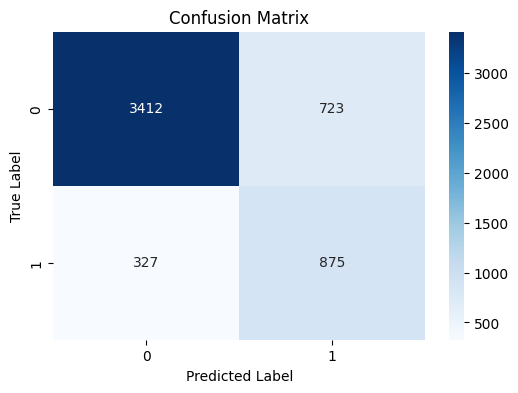

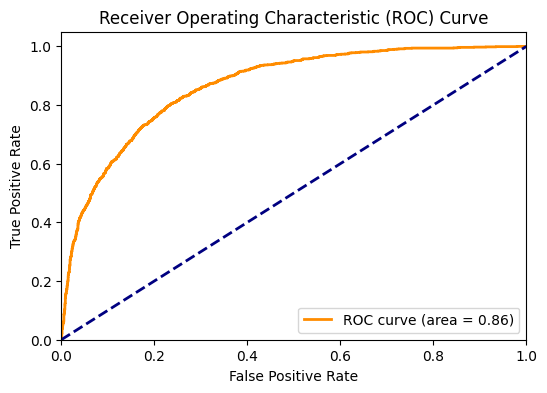

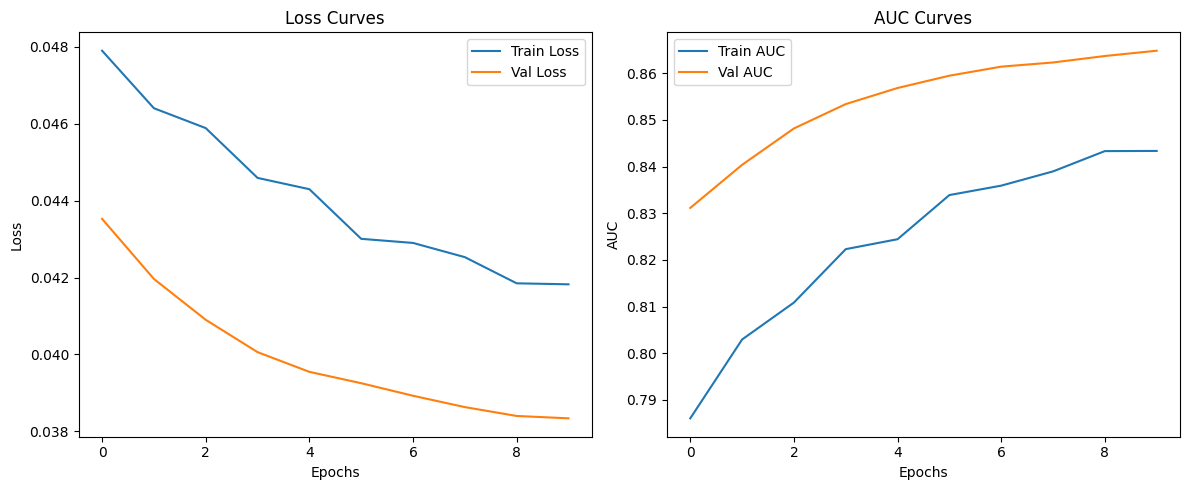

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ------------------------------
# 1. Evaluate the Model on Validation Set
# ------------------------------
val_loss, val_auc = model.evaluate(val_generator, verbose=1)
print("Validation Loss:", val_loss)
print("Validation AUC:", val_auc)

# ------------------------------
# 2. Generate Predictions and Compute Additional Metrics
# ------------------------------
# Reset the generator and get predictions
val_generator.reset()
preds = model.predict(val_generator, verbose=1)

# Ensure preds is a 1D array by removing extra dimensions
preds = np.squeeze(preds)
print("Predictions shape:", preds.shape)

# Apply a threshold of 0.5 to get binary predictions
pred_labels = (preds > 0.34).astype(int)
print("Predicted labels shape:", pred_labels.shape)

# Get true labels from your validation DataFrame (assumed to be 'val_df')
true_labels = val_df['pneumonia_label'].values
print("True labels shape:", true_labels.shape)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Normal', 'Pneumonia']))

# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# 3. Plot the ROC Curve
# ------------------------------
fpr, tpr, thresholds = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# ------------------------------
# 4. Plot Learning Curves from Fine-Tuning History
# ------------------------------
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    
    # Plot AUC Curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.title("AUC Curves")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the learning curves using the fine-tuning history (assumed to be stored in 'history_fine')
plot_learning_curves(history_fine)


In [46]:
 # !pip install tf2onnx

In [49]:
import tensorflow as tf
import pickle
import os
import tf2onnx

# ---------------------------
# 1. Save as H5 Format
# ---------------------------
# This saves the full model (architecture, weights, and optimizer state)
model.save('model.h5')
print("Model saved as 'model.h5'")

# ---------------------------
# 2. Save as Keras Native Format (.keras)
# ---------------------------
# Save the model using the native Keras format (the file must end with '.keras')
model.save('model_tf.keras')
print("Model saved in Keras native format as 'model_tf.keras'")

# ---------------------------
# 3. Save as ONNX Format
# ---------------------------
# Uncomment the next line if tf2onnx is not installed:
# !pip install tf2onnx
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=output_path)
print("Model converted and saved as ONNX format in 'model.onnx'")

# ---------------------------
# 4. Save Weights Using Pickle (Weights Only)
# ---------------------------
weights = model.get_weights()
with open("model_weights.pkl", "wb") as f:
    pickle.dump(weights, f)
print("Model weights saved using pickle as 'model_weights.pkl'")

# ---------------------------
# 5. Save Model Architecture as JSON
# ---------------------------
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as 'model_architecture.json'")

# ---------------------------
# 6. Save as TensorFlow SavedModel Format (Using model.export)
# ---------------------------
# Use model.export() to export a TensorFlow SavedModel (for TFLite/TFServing, etc.)
model.export("saved_model_dir")
print("Model exported in TensorFlow SavedModel format in folder 'saved_model_dir'")

# ---------------------------
# 7. Attempt to Save Full Model Using Pickle (Not Recommended)
# ---------------------------
try:
    with open("full_model.pkl", "wb") as f:
        pickle.dump(model, f)
    print("Full model saved using pickle as 'full_model.pkl'")
except Exception as e:
    print("Error saving full model with pickle:", str(e))


Model saved as 'model.h5'
Model saved in Keras native format as 'model_tf.keras'
Model converted and saved as ONNX format in 'model.onnx'
Model weights saved using pickle as 'model_weights.pkl'
Model architecture saved as 'model_architecture.json'
Saved artifact at 'saved_model_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134826945300256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134826945305184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134826945306944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134826945301664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134826945305712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134826945313104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134826945299200: TensorSpec(shape=(), dtype=tf.

In [50]:
# import os
# import zipfile

# def zip_folder(folder_path, output_path):
#     """
#     Zips the entire contents of folder_path into a single zip file at output_path.
#     """
#     with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 # Create an archive name relative to the folder_path
#                 arcname = os.path.relpath(file_path, start=folder_path)
#                 zipf.write(file_path, arcname)
                
# # Define the folder to zip and the output zip file
# folder_to_zip = "saved_model_dir"
# output_zip = "saved_model_dir.zip"

# zip_folder(folder_to_zip, output_zip)
# print(f"Folder '{folder_to_zip}' has been zipped into '{output_zip}'.")


Folder 'saved_model_dir' has been zipped into 'saved_model_dir.zip'.


In [56]:
import random
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Define the PNG images directory (where the converted images are stored)
PNG_DIR = "/content/rsna-dataset/train_png"

# Prepare indices for each class from val_df for balanced sampling
indices_class0 = val_df[val_df['pneumonia_label'] == 0].index.tolist()
indices_class1 = val_df[val_df['pneumonia_label'] == 1].index.tolist()

# Output widget to display the image and info
output = widgets.Output()

def show_random_patient_balanced(b=None):
    """Randomly selects a patient from the validation set in a balanced way,
    loads the corresponding image, preprocesses it, runs the model prediction,
    and displays the image along with the model's prediction and actual label."""
    with output:
        output.clear_output(wait=True)
        
        # Randomly choose which class to sample from (50% chance each)
        if random.random() < 0.5 and len(indices_class0) > 0:
            chosen_index = random.choice(indices_class0)
        elif len(indices_class1) > 0:
            chosen_index = random.choice(indices_class1)
        else:
            # Fallback: if one list is empty, choose from the other
            chosen_index = random.choice(val_df.index)
        
        # Retrieve the row from val_df
        row = val_df.loc[chosen_index]
        filepath = row['filepath']  # Full path to the PNG image
        actual_label = row['pneumonia_label']  # 0 for Normal, 1 for Pneumonia

        # Check that the image file exists
        if not os.path.exists(filepath):
            print(f"Image not found at: {filepath}")
            return

        # Load the image using cv2 (which reads in BGR order)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Failed to load image from {filepath}")
            return

        # Convert the image from BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image to 224x224 and normalize pixel values to [0, 1]
        img_resized = cv2.resize(img_rgb, (224, 224))
        img_norm = img_resized.astype(np.float32) / 255.0
        # Prepare model input by adding a batch dimension: shape becomes (1, 224, 224, 3)
        input_img = np.expand_dims(img_norm, axis=0)
        
        # Run model prediction; output is a probability between 0 and 1
        pred_prob = model.predict(input_img)[0][0]
        threshold = 0.34
        pred_label = "Pneumonia" if pred_prob > threshold else "Normal"

        # Display the image with prediction and actual label in the title
        plt.figure(figsize=(6,6))
        plt.imshow(img_rgb)
        plt.title(f"Model Prediction: {pred_label} ({pred_prob:.2f})\nActual Label: {actual_label}")
        plt.axis("off")
        plt.show()

# Create a button widget to load the next random patient image
next_button = widgets.Button(description="Next Random Patient")
next_button.on_click(show_random_patient_balanced)

# Display the button and output widget together
display(widgets.VBox([next_button, output]))

# Show an initial random patient image
show_random_patient_balanced()
